In [116]:
# ============================================================================
# MNIST CNN Classification - Two Conv Blocks (Conv → ReLU → MaxPool) → Dense
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Use TensorFlow Keras to avoid import mismatches
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

In [117]:
# ============================================================================
# HYPERPARAMETERS 
# ============================================================================
F1, F2        = 16, 32      # filters in conv block 1 and 2
KERNEL_SIZE   = 3           # conv kernel size
POOL_SIZE     = 2           # maxpool size
DENSE_UNITS   = 128         # dense layer size
DROPOUT_DENSE = 0.3         # dropout before final softmax (set 0.0 to disable)

OPTIMIZER     = "sgd"      # "adam" or "sgd"
LR            = 1e-3        # learning rate 

BATCH_SIZE    = 128
EPOCHS        = 20
VAL_SPLIT     = 0.1
PATIENCE_ES   = 3           # early stopping patience (set None to disable)

In [118]:
# ============================================================================
# SECTION 1: DATA LOADING AND EXPLORATION
# ============================================================================
print("Loading MNIST dataset...")
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"Training images shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test images shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Unique labels
print(f"Class Labels in Training Set: {np.unique(y_train)}")
print(f"Class Labels in Test Set: {np.unique(y_test)}")

Loading MNIST dataset...
Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)
Class Labels in Training Set: [0 1 2 3 4 5 6 7 8 9]
Class Labels in Test Set: [0 1 2 3 4 5 6 7 8 9]


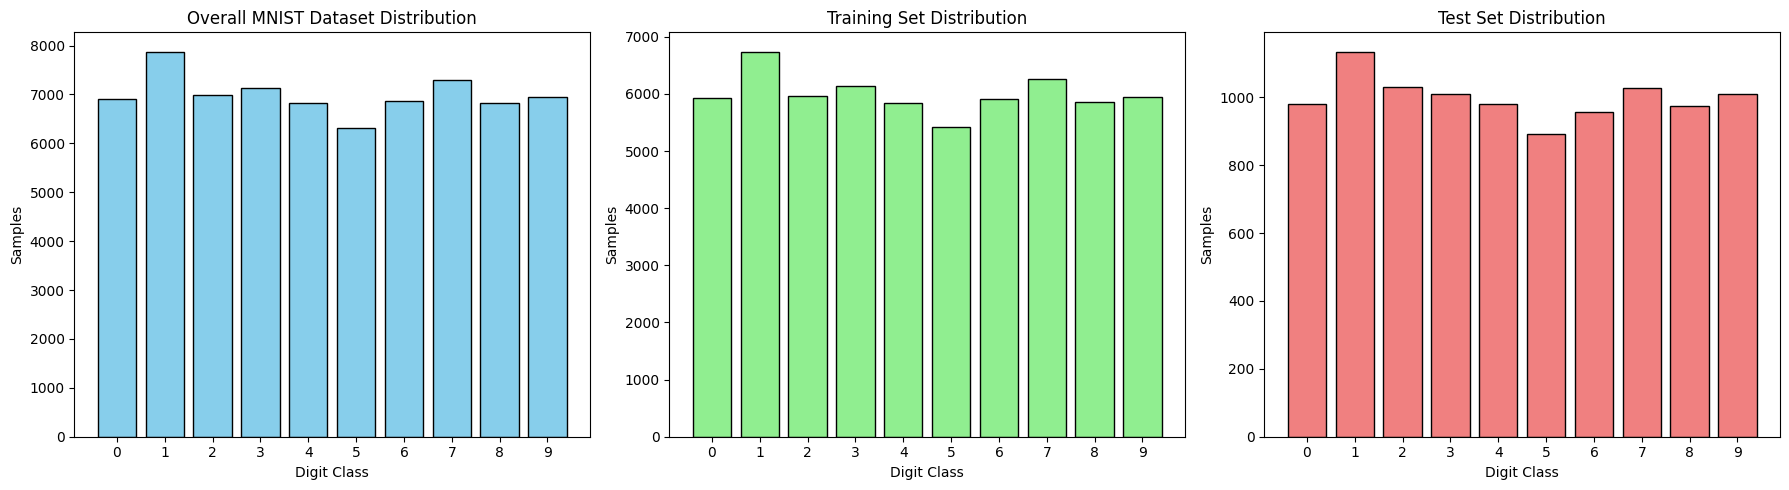

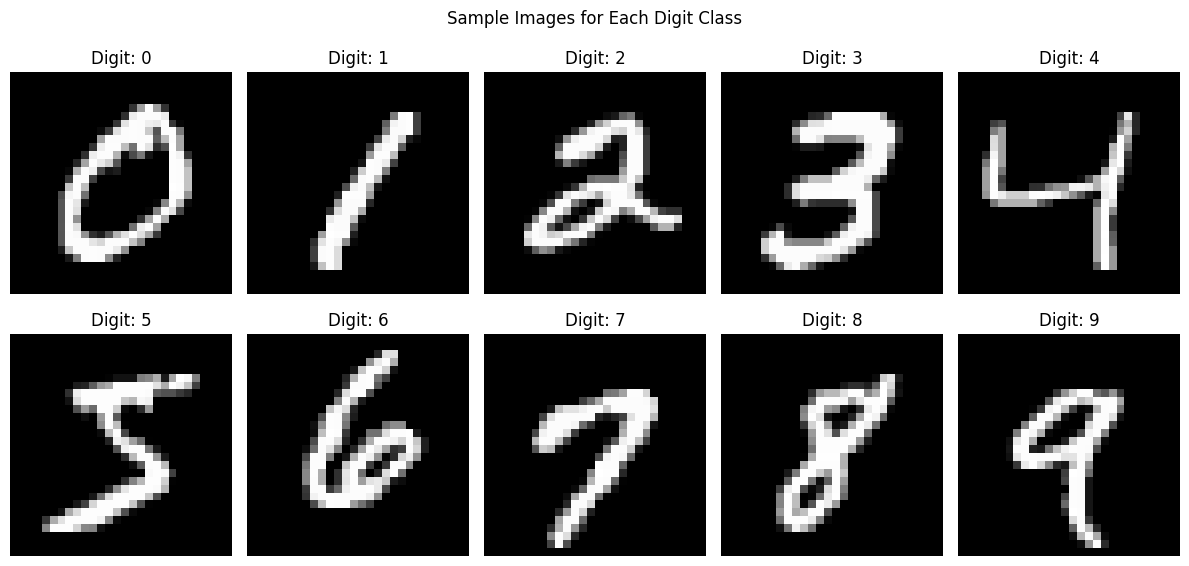

In [119]:
# ============================================================================
# SECTION 2: DATA VISUALIZATION AND DISTRIBUTION ANALYSIS
# ============================================================================
# Class distributions
y_all = np.concatenate([y_train, y_test])
class_counts_all = np.bincount(y_all, minlength=10)
class_counts_train = np.bincount(y_train, minlength=10)
class_counts_test = np.bincount(y_test, minlength=10)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].bar(range(10), class_counts_all, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Digit Class'); axes[0].set_ylabel('Samples')
axes[0].set_title('Overall MNIST Dataset Distribution'); axes[0].set_xticks(range(10))

axes[1].bar(range(10), class_counts_train, color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Digit Class'); axes[1].set_ylabel('Samples')
axes[1].set_title('Training Set Distribution'); axes[1].set_xticks(range(10))

axes[2].bar(range(10), class_counts_test, color='lightcoral', edgecolor='black')
axes[2].set_xlabel('Digit Class'); axes[2].set_ylabel('Samples')
axes[2].set_title('Test Set Distribution'); axes[2].set_xticks(range(10))

plt.tight_layout(); plt.show()

# Sample images (one per class)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    idx = np.where(y_train == i)[0][0]
    r, c = i // 5, i % 5
    axes[r, c].imshow(X_train[idx], cmap='gray')
    axes[r, c].set_title(f'Digit: {i}')
    axes[r, c].axis('off')
plt.suptitle('Sample Images for Each Digit Class')
plt.tight_layout(); plt.show()

In [120]:
# ============================================================================
# SECTION 3: DATA PREPROCESSING FOR CNN
# ============================================================================
print("Preprocessing data for CNN...")

# Add channel dimension; normalize to [0,1]
X_train_cnn = (X_train.astype('float32') / 255.0)[..., np.newaxis]
X_test_cnn  = (X_test.astype('float32')  / 255.0)[..., np.newaxis]

print(f"Reshaped training data: {X_train_cnn.shape}")
print(f"Reshaped test data: {X_test_cnn.shape}")

# One-hot encoding
y_train_cnn = to_categorical(y_train, num_classes=10)
y_test_cnn  = to_categorical(y_test,  num_classes=10)
print(f"One-hot encoded labels shape: {y_train_cnn.shape}")

Preprocessing data for CNN...
Reshaped training data: (60000, 28, 28, 1)
Reshaped test data: (10000, 28, 28, 1)
One-hot encoded labels shape: (60000, 10)


In [121]:
# ============================================================================
# SECTION 4: CNN MODEL ARCHITECTURE 
# ============================================================================
print("Building CNN model (2 conv blocks → dense)...")

model = Sequential([
    # Block 1: Conv → ReLU → MaxPool
    Conv2D(F1, (KERNEL_SIZE, KERNEL_SIZE), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(POOL_SIZE, POOL_SIZE)),

    # Block 2: Conv → ReLU → MaxPool
    Conv2D(F2, (KERNEL_SIZE, KERNEL_SIZE), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(POOL_SIZE, POOL_SIZE)),

    # Classifier head
    Flatten(),
    Dense(DENSE_UNITS, activation='relu'),
    Dropout(DROPOUT_DENSE) if DROPOUT_DENSE > 0 else Dropout(0.0),
    Dense(10, activation='softmax')
])

print("\nCNN Model Architecture:")
model.summary()

Building CNN model (2 conv blocks → dense)...

CNN Model Architecture:


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,922 (808.29 KB)

 Trainable params: 206,922 (808.29 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
# ============================================================================
# SECTION 5: MODEL COMPILATION
# ============================================================================
print("Compiling the model...")
if OPTIMIZER.lower() == "sgd":
    optimizer = SGD(learning_rate=LR, momentum=0.9)
else:
    optimizer = Adam(learning_rate=LR)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
print("Model compiled successfully!")

Compiling the model...
Model compiled successfully!


In [123]:
# ============================================================================
# SECTION 6: MODEL TRAINING (WITH VALIDATION)
# ============================================================================
print("Training the CNN model...")

callbacks = []
if PATIENCE_ES is not None:
    callbacks.append(EarlyStopping(monitor="val_accuracy", patience=PATIENCE_ES, restore_best_weights=True))

history = model.fit(
    X_train_cnn, y_train_cnn,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VAL_SPLIT,
    verbose=1,
    shuffle=True,
    callbacks=callbacks
)

print("Training completed!")

Training the CNN model...
Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5387 - loss: 1.5498 - val_accuracy: 0.8992 - val_loss: 0.4241
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8592 - loss: 0.4635 - val_accuracy: 0.9372 - val_loss: 0.2341
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9012 - loss: 0.3284 - val_accuracy: 0.9477 - val_loss: 0.1840
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9193 - loss: 0.2662 - val_accuracy: 0.9573 - val_loss: 0.1520
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9319 - loss: 0.2268 - val_accuracy: 0.9650 - val_loss: 0.1306
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9407 - loss: 0.1992 - val_accuracy: 0.9685 - val_loss: 0.1158
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9459 - loss: 0.1799 - val_accuracy: 0.9700 - val_loss: 0.1048
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9515 - loss:

In [124]:
# ============================================================================
# SECTION 7: MODEL EVALUATION (TEST SET)
# ============================================================================
print("Evaluating the model...")
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions
y_prob = model.predict(X_test_cnn, batch_size=256, verbose=0)
y_pred_classes = np.argmax(y_prob, axis=1)
y_true_classes = np.argmax(y_test_cnn, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

Evaluating the model...
Test Loss: 0.0628
Test Accuracy: 0.9797

Classification Report:
              precision    recall  f1-score   support

           0     0.9739    0.9908    0.9823       980
           1     0.9886    0.9903    0.9894      1135
           2     0.9823    0.9700    0.9761      1032
           3     0.9651    0.9851    0.9750      1010
           4     0.9817    0.9837    0.9827       982
           5     0.9864    0.9765    0.9814       892
           6     0.9803    0.9854    0.9828       958
           7     0.9776    0.9786    0.9781      1028
           8     0.9754    0.9754    0.9754       974
           9     0.9858    0.9604    0.9729      1009

    accuracy                         0.9797     10000
   macro avg     0.9797    0.9796    0.9796     10000
weighted avg     0.9798    0.9797    0.9797     10000



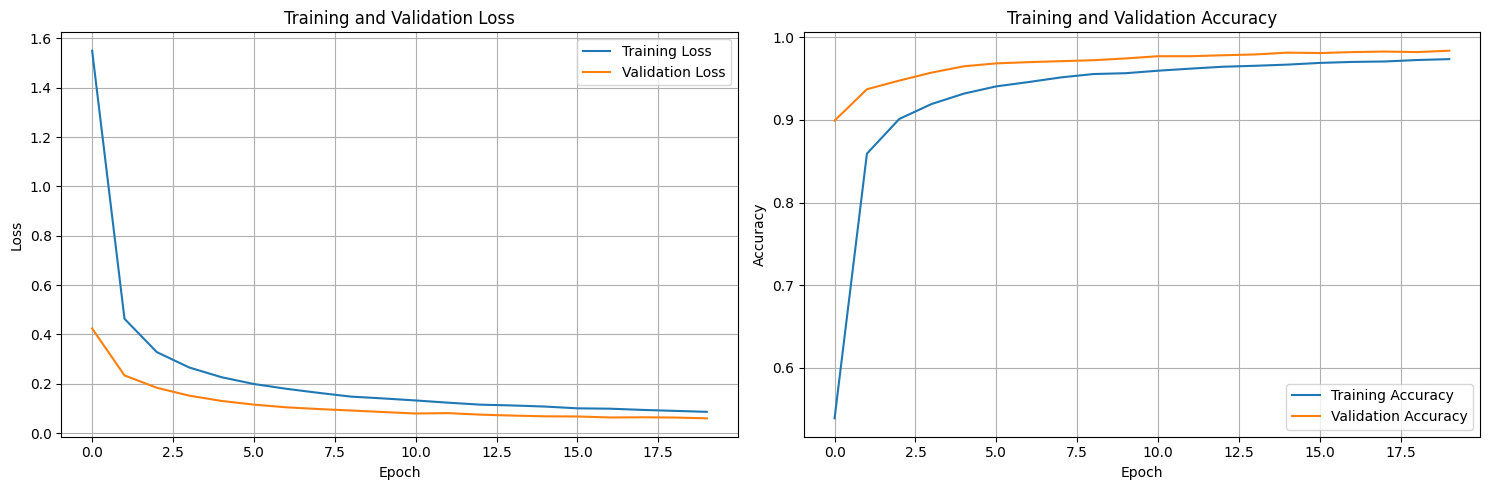

In [125]:
# ============================================================================
# SECTION 8: TRAINING HISTORY VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss'); axes[0].legend(); axes[0].grid(True)

axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy'); axes[1].legend(); axes[1].grid(True)

plt.tight_layout(); plt.show()

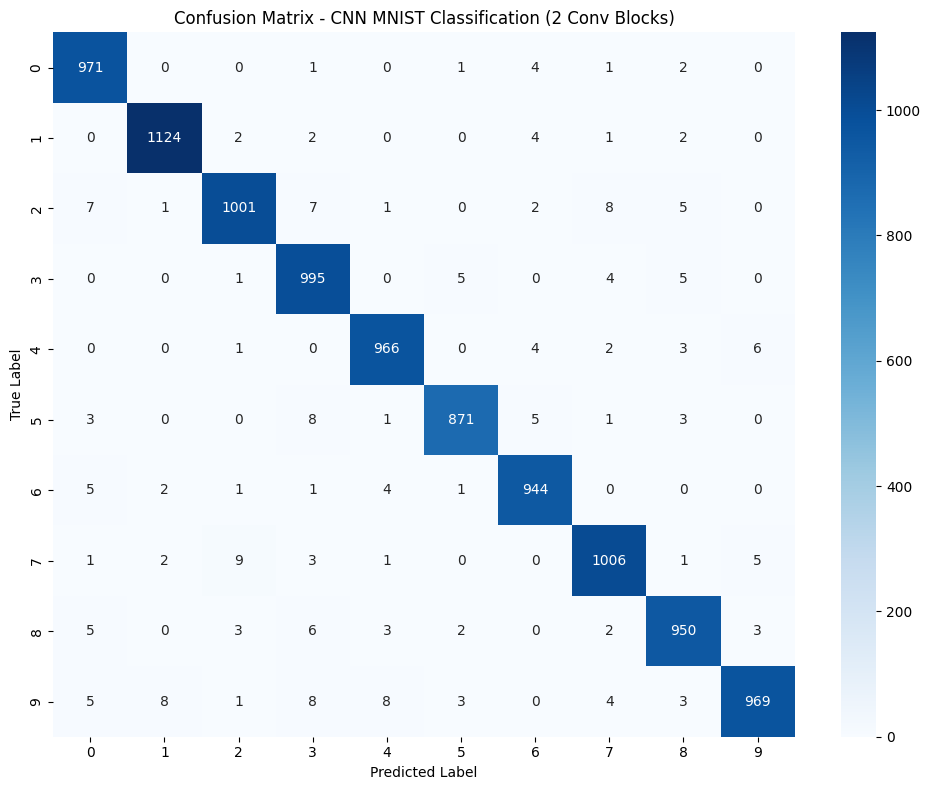

In [126]:
# ============================================================================
# SECTION 9: CONFUSION MATRIX VISUALIZATION
# ============================================================================
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label'); plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN MNIST Classification (2 Conv Blocks)')
plt.tight_layout(); plt.show()

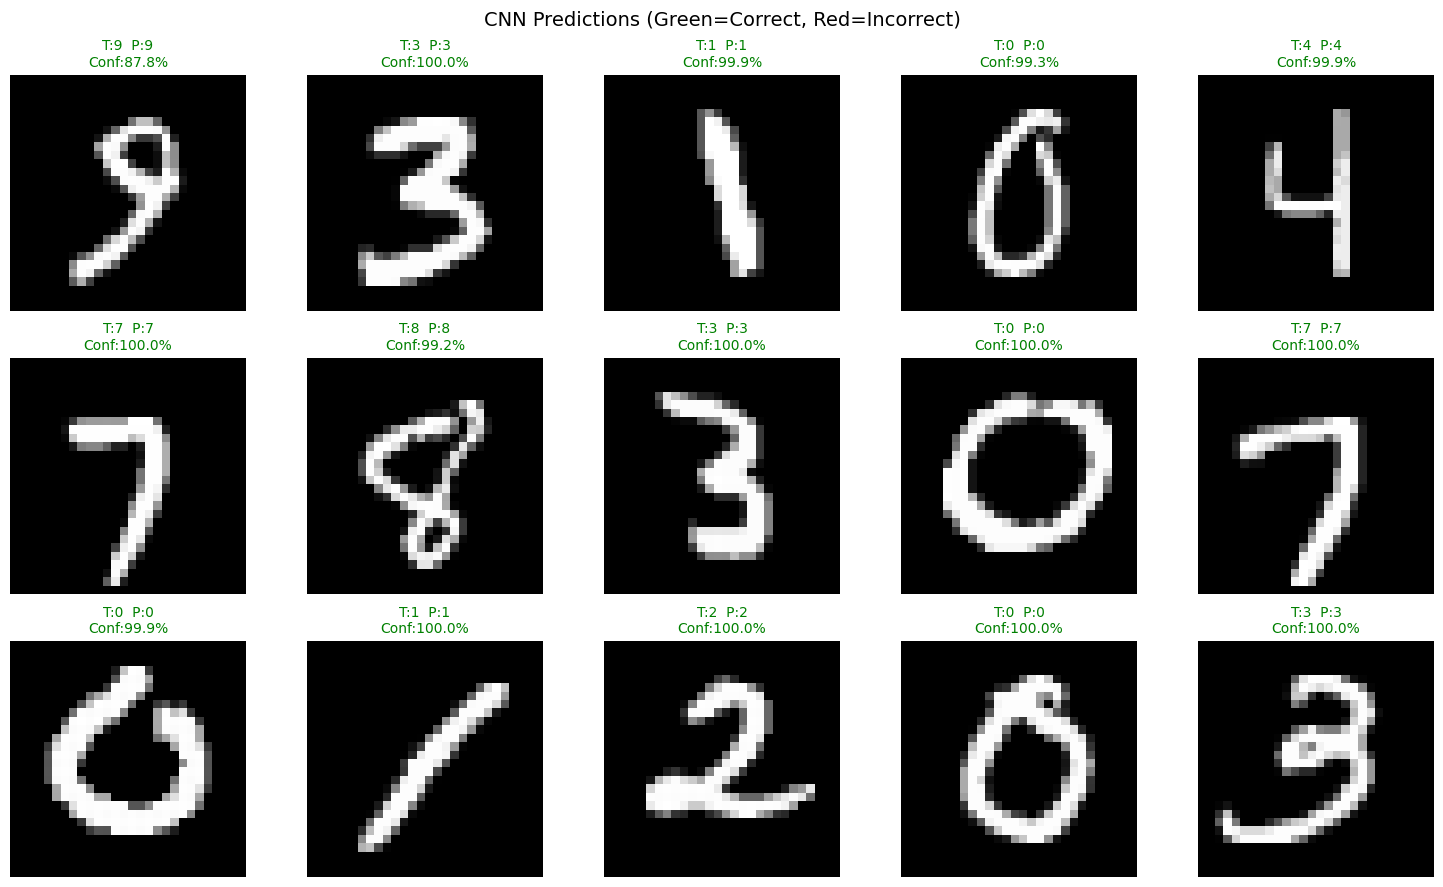

In [127]:
# ============================================================================
# SECTION 10: PREDICTION VISUALIZATION ON SAMPLE IMAGES
# ============================================================================
num_examples = 15
random_indices = np.random.randint(0, len(X_test_cnn), num_examples)
X_examples = X_test_cnn[random_indices]
y_true_examples = y_true_classes[random_indices]

y_pred_examples = model.predict(X_examples, verbose=0)
y_pred_labels = np.argmax(y_pred_examples, axis=1)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for i in range(num_examples):
    r, c = i // 5, i % 5
    axes[r, c].imshow(X_examples[i].reshape(28, 28), cmap='gray')
    axes[r, c].axis('off')
    color = 'green' if y_true_examples[i] == y_pred_labels[i] else 'red'
    confidence = np.max(y_pred_examples[i]) * 100
    axes[r, c].set_title(f'T:{y_true_examples[i]}  P:{y_pred_labels[i]}\nConf:{confidence:.1f}%', color=color, fontsize=10)

plt.suptitle('CNN Predictions (Green=Correct, Red=Incorrect)', fontsize=14)
plt.tight_layout(); plt.show()

In [128]:
# ============================================================================
# SECTION 11: MODEL PERFORMANCE SUMMARY
# ============================================================================
print("\n" + "="*60)
print("CNN MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Total Parameters: {model.count_params():,}")

# Per-class accuracy
for i in range(10):
    mask = (y_true_classes == i)
    if np.sum(mask) > 0:
        class_acc = np.mean(y_pred_classes[mask] == i)
        print(f"Class {i} Accuracy: {class_acc:.4f} ({class_acc*100:.2f}%)")
print("="*60)
print("CNN implementation completed successfully!")


CNN MODEL PERFORMANCE SUMMARY
Final Test Accuracy: 0.9797 (97.97%)
Final Test Loss: 0.0628
Total Parameters: 206,922
Class 0 Accuracy: 0.9908 (99.08%)
Class 1 Accuracy: 0.9903 (99.03%)
Class 2 Accuracy: 0.9700 (97.00%)
Class 3 Accuracy: 0.9851 (98.51%)
Class 4 Accuracy: 0.9837 (98.37%)
Class 5 Accuracy: 0.9765 (97.65%)
Class 6 Accuracy: 0.9854 (98.54%)
Class 7 Accuracy: 0.9786 (97.86%)
Class 8 Accuracy: 0.9754 (97.54%)
Class 9 Accuracy: 0.9604 (96.04%)
CNN implementation completed successfully!
